In [1]:
# %%bash
# conda install -c conda-forge vaex

## References

- https://vaex.io/docs/tutorial.html

In [2]:
import vaex
df = vaex.example()
# df  # Since this is the last statement in a cell, it will print the DataFrame in a nice HTML format.

In [3]:
df.x

Expression = x
Length: 330,000 dtype: float32 (column)
---------------------------------------
     0    1.23187
     1  -0.163701
     2   -2.12026
     3    4.71559
     4    7.21719
       ...       
329995    1.99387
329996    3.71809
329997   0.368851
329998  -0.112593
329999    20.7962

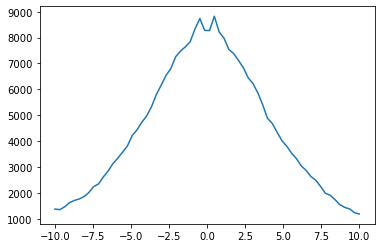

In [4]:
import numpy as np
import matplotlib.pylab as plt

counts_x = df.count(binby=df.x, limits=[-10, 10], shape=64)
plt.plot(np.linspace(-10, 10, 64), counts_x)
plt.show()

In [5]:
import vaex
import numpy as np
x = np.arange(5)
y = x**2
df = vaex.from_arrays(x=x, y=y)
df

#,x,y
0,0,0
1,1,1
2,2,4
3,3,9
4,4,16


In [6]:
# Read in the NYC Taxi dataset straight from S3
nyctaxi = vaex.open('s3://vaex/taxi/yellow_taxi_2009_2015_f32.hdf5?anon=true')
nyctaxi.head(5)

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.63,-73.992,40.7216,nan,nan,-73.9938,40.6959,8.9,0.5,nan,0,0,9.4
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.55,-73.9821,40.7363,nan,nan,-73.9558,40.768,12.1,0.5,nan,2,0,14.6
2,VTS,2009-01-03 15:43:00.000000000,2009-01-03 15:57:00.000000000,5,Credit,10.35,-74.0026,40.7397,nan,nan,-73.87,40.7702,23.7,0,nan,4.74,0,28.44
3,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5,-73.9743,40.791,nan,nan,-73.9966,40.7318,14.9,0.5,nan,3.05,0,18.45
4,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4,-74.0016,40.7194,nan,nan,-74.0084,40.7203,3.7,0,nan,0,0,3.7


the data from S3 above were cached on disk 

## Data Reading

In [8]:
input_file = "/data/raw_data/spectx_cell_mapping_test/cell_mapping_1gb.csv"
df_tmp = vaex.from_csv(input_file, convert=True, copy_index=False)
df = vaex.open(input_file + '.hdf5')
df

#,mno_ms_id,pos_time,mno_cell_id
0,617487,2019-01-01 17:06:30,11891
1,617487,2019-01-01 07:01:44,9810
2,617487,2019-01-01 14:14:09,7534
3,617487,2019-01-01 11:51:41,545
4,617487,2019-01-01 07:23:54,9752
...,...,...,...
"31,486,158",861822,2019-01-31 04:15:07,5248
"31,486,159",861822,2019-01-31 17:49:50,1210
"31,486,160",861822,2019-01-31 09:54:36,2439
"31,486,161",861822,2019-01-31 12:10:28,14092


## Parallel computations

- Vaex can do computations in parallel similar as in [joblib](https://joblib.readthedocs.io/en/latest/index.html) and `dask`

In [9]:
import vaex
df = vaex.example()
limits = [-10, 10]
delayed_count = df.count(df.E, binby=df.x, limits=limits,
                         shape=4, delay=True)
delayed_count



In [10]:
delayed_sum = df.sum(df.E, binby=df.x, limits=limits,
                         shape=4, delay=True)

@vaex.delayed
def calculate_mean(sums, counts):
    print('calculating mean')
    return sums/counts

print('before calling mean')
# since calculate_mean is decorated with vaex.delayed
# this now also returns a 'delayed' object (a promise)
delayed_mean = calculate_mean(delayed_sum, delayed_count)

# if we'd like to perform operations on that, we can again
# use the same decorator
@vaex.delayed
def print_mean(means):
    print('means', means)
print_mean(delayed_mean)

print('before calling execute')
df.execute()

# Using the .get on the promise will also return the result
# However, this will only work after execute, and may be
# subject to change
means = delayed_mean.get()
print('same means', means)


before calling mean
before calling execute
calculating mean
means [ -94323.68051598 -118749.23850834 -119119.46292653  -95021.66183457]
same means [ -94323.68051598 -118749.23850834 -119119.46292653  -95021.66183457]


## Machine Learning with vaex.ml

In [11]:
import vaex
vaex.multithreading.thread_count_default = 8
import vaex.ml

import numpy as np
import pylab as plt

In [12]:
df = vaex.ml.datasets.load_iris()
dfdf.scatter(df.petal_length, df.petal_width, c_expr=df.class_);

#,sepal_length,sepal_width,petal_length,petal_width,class_
0,5.9,3.0,4.2,1.5,1
1,6.1,3.0,4.6,1.4,1
2,6.6,2.9,4.6,1.3,1
3,6.7,3.3,5.7,2.1,2
4,5.5,4.2,1.4,0.2,0
...,...,...,...,...,...
145,5.2,3.4,1.4,0.2,0
146,5.1,3.8,1.6,0.2,0
147,5.8,2.6,4.0,1.2,1
148,5.7,3.8,1.7,0.3,0


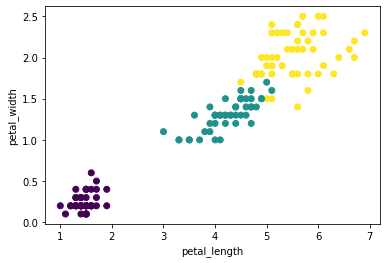

In [13]:
df.scatter(df.petal_length, df.petal_width, c_expr=df.class_);

In [14]:
features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']
scaler = vaex.ml.StandardScaler(features=features, prefix='scaled_')
scaler.fit(df)
df_trans = scaler.transform(df)
df_trans

#,sepal_length,sepal_width,petal_length,petal_width,class_,scaled_petal_length,scaled_petal_width,scaled_sepal_length,scaled_sepal_width
0,5.9,3.0,4.2,1.5,1,0.25096730693923325,0.39617188299171285,0.06866179325140277,-0.12495760117130607
1,6.1,3.0,4.6,1.4,1,0.4784301228962429,0.26469891297233916,0.3109975341387059,-0.12495760117130607
2,6.6,2.9,4.6,1.3,1,0.4784301228962429,0.13322594295296575,0.9168368863569659,-0.3563605663033572
3,6.7,3.3,5.7,2.1,2,1.1039528667780207,1.1850097031079545,1.0380047568006185,0.5692512942248463
4,5.5,4.2,1.4,0.2,0,-1.341272404759837,-1.3129767272601438,-0.4160096885232057,2.6518779804133055
...,...,...,...,...,...,...,...,...,...
145,5.2,3.4,1.4,0.2,0,-1.341272404759837,-1.3129767272601438,-0.7795132998541615,0.8006542593568975
146,5.1,3.8,1.6,0.2,0,-1.2275409967813318,-1.3129767272601438,-0.9006811702978141,1.726266119885101
147,5.8,2.6,4.0,1.2,1,0.13723589896072813,0.0017529729335920385,-0.052506077192249874,-1.0505694616995096
148,5.7,3.8,1.7,0.3,0,-1.1706752927920796,-1.18150375724077,-0.17367394763590144,1.726266119885101


### Encoding of Categorical Features

In [15]:
df =  vaex.ml.datasets.load_titanic()
df.head(5)

#,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest
0,1,True,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.338,B5,S,2,nan,"St Louis, MO"
1,1,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,nan,"Montreal, PQ / Chesterville, ON"
2,1,False,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,None,nan,"Montreal, PQ / Chesterville, ON"
3,1,False,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,None,135,"Montreal, PQ / Chesterville, ON"
4,1,False,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,None,nan,"Montreal, PQ / Chesterville, ON"


In [16]:
label_encoder = vaex.ml.LabelEncoder(features=['embarked'])
one_hot_encoder = vaex.ml.OneHotEncoder(features=['embarked'])
freq_encoder = vaex.ml.FrequencyEncoder(features=['embarked'])
bayes_encoder = vaex.ml.BayesianTargetEncoder(features=['embarked'], target='survived')
woe_encoder = vaex.ml.WeightOfEvidenceEncoder(features=['embarked'], target='survived')

df = label_encoder.fit_transform(df)
df = one_hot_encoder.fit_transform(df)
df = freq_encoder.fit_transform(df)
df = bayes_encoder.fit_transform(df)
df = woe_encoder.fit_transform(df)

df.head(5)

INFO:MainThread:numexpr.utils:NumExpr defaulting to 6 threads.


#,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest,label_encoded_embarked,embarked_0.0,embarked_C,embarked_Q,embarked_S,frequency_encoded_embarked,mean_encoded_embarked,woe_encoded_embarked
0,1,True,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.338,B5,S,2,nan,"St Louis, MO",1,0,0,0,1,0.698243,0.337472,-0.696431
1,1,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431
2,1,False,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,None,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431
3,1,False,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,None,135,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431
4,1,False,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,None,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431


### Scikit-Learn example

In [19]:
from vaex.ml.sklearn import Predictor
from sklearn.ensemble import GradientBoostingClassifier

df = vaex.ml.datasets.load_iris()

features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']
target = 'class_'

model = GradientBoostingClassifier(random_state=42)
vaex_model = Predictor(features=features, target=target, model=model, prediction_name='prediction')

vaex_model.fit(df=df)

df = vaex_model.transform(df)
df

#,sepal_length,sepal_width,petal_length,petal_width,class_,prediction
0,5.9,3.0,4.2,1.5,1,1
1,6.1,3.0,4.6,1.4,1,1
2,6.6,2.9,4.6,1.3,1,1
3,6.7,3.3,5.7,2.1,2,2
4,5.5,4.2,1.4,0.2,0,0
...,...,...,...,...,...,...
145,5.2,3.4,1.4,0.2,0,0
146,5.1,3.8,1.6,0.2,0,0
147,5.8,2.6,4.0,1.2,1,1
148,5.7,3.8,1.7,0.3,0,0


## I/O Kung-Fu

- Binary file:
 - HDF5
 - Arrow
 - Parquet
 - FITS

- Text file:
 - CSV
 - ASCII
 - JSON
 
- Cloud support:
 - Google Cloud Storage
 - AWS S3

- Extras:
 - Aliases

In [21]:
# Convert from pandas dataframe to vaex dataframe
import pandas as pd

pandas_df = pd.read_csv('/data/raw_data/spectx_cell_mapping_test/cell_mapping_1gb.csv')
pandas_df

,mno_ms_id,pos_time,mno_cell_id
0,617487,2019-01-01 17:06:30,11891
1,617487,2019-01-01 07:01:44,9810
2,617487,2019-01-01 14:14:09,7534
3,617487,2019-01-01 11:51:41,545
4,617487,2019-01-01 07:23:54,9752
...,...,...,...
31486158,861822,2019-01-31 04:15:07,5248
31486159,861822,2019-01-31 17:49:50,1210
31486160,861822,2019-01-31 09:54:36,2439
31486161,861822,2019-01-31 12:10:28,14092


In [22]:
df = vaex.from_pandas(df=pandas_df, copy_index=True)
df

#,mno_ms_id,pos_time,mno_cell_id,index
0,617487,2019-01-01 17:06:30,11891,0
1,617487,2019-01-01 07:01:44,9810,1
2,617487,2019-01-01 14:14:09,7534,2
3,617487,2019-01-01 11:51:41,545,3
4,617487,2019-01-01 07:23:54,9752,4
...,...,...,...,...
"31,486,158",861822,2019-01-31 04:15:07,5248,31486158
"31,486,159",861822,2019-01-31 17:49:50,1210,31486159
"31,486,160",861822,2019-01-31 09:54:36,2439,31486160
"31,486,161",861822,2019-01-31 12:10:28,14092,31486161


Info from above process:

- pandas still powerful data reader, as it can read data from almost all kind of data sources including databases
- by reading it first using pandas and then convert it into vaex when it's needed for multi-processing

In [27]:
import vaex
import pandas as pd
import sqlalchemy

connection_string = 'postgresql://enlik:' + 'Zg7vcQ9E1BF394Kg' + '@localhost:5432/spectx_test_ee'
engine = sqlalchemy.create_engine(connection_string)

pandas_df = pd.read_sql_query('select * from ee_telia_cells.cell where geom is not null', con=engine)
df = vaex.from_pandas(pandas_df, copy_index=False)
df

#,cell_id,mno_cell_id,valid_date_range,valid_date,is_err,geom,geom_srs_eucl,geom_srs_eucl_generalized
0,1,1,"(None, None)",2018-01-01,False,0101000020E61000002AAD785034863940F6A7212AECCA4D40,0101000020E50C00004DD2F5A800E3214154116FFD76335941,0101000020E50C000000000000B0E32141000000005E335941
1,10,10,"(None, None)",2018-01-01,False,0101000020E61000005D62ED6E6C7D3840215A81DAF59E4D40,0101000020E50C0000E1F3C275B11C2041722E1D553E0D5941,0101000020E50C000000000000001D204100000000480D5941
2,100,100,"(None, None)",2018-01-01,False,0101000020E6100000CCE3124225C239406DE578907D924D40,0101000020E50C000050BCE1FA61542241F89A837BD5035941,0101000020E50C0000000000003054224100000000E8035941
3,1000,1000,"(None, None)",2018-01-01,False,0101000020E6100000CB114C9B4C7E36404A2289CB62224D40,0101000020E50C000004E2285C0D1F19411304EA1140A45841,0101000020E50C000000000000401F19410000000034A45841
4,9516,10000,"(None, None)",2018-01-01,False,0101000020E610000050C666F20E453B4099D338676AB34D40,0101000020E50C0000BD2C152EC4EC2441E5C0DFFAF2225941,0101000020E50C00000000000040EC244100000000F6225941
...,...,...,...,...,...,...,...,...
"13,980",9511,9995,"(None, None)",2018-01-01,False,0101000020E6100000E7A4A521CB693B400B9FE5E422AD4D40,0101000020E50C000018E6B89E8A2E2541D5FEE9F1031E5941,0101000020E50C000000000000E02D254100000000141E5941
"13,981",9512,9996,"(None, None)",2018-01-01,False,0101000020E61000008FF38D58EAFB3A40B53AF7267FAD4D40,0101000020E50C00008A90A470E56F2441AE9C5A4F2F1D5941,0101000020E50C000000000000406F2441000000001A1D5941
"13,982",9513,9997,"(None, None)",2018-01-01,False,0101000020E6100000A1202B12F03D3B40302C0AFA95B24D40,0101000020E50C00000DD8B89EB5E02441AD2398792B225941,0101000020E50C00000000000050E12441000000002E225941
"13,983",9514,9998,"(None, None)",2018-01-01,False,0101000020E6100000D3FB64D248323B400A094EBD92AC4D40,0101000020E50C000024C2008079CE2441B61A46B1F11C5941,0101000020E50C00000000000090CE244100000000E81C5941


### Vaex Extras: using Aliases

In [31]:
vaex.aliases['input_1gb'] = '/data/raw_data/spectx_cell_mapping_test/cell_mapping_1gb.csv'
vaex.aliases['nyc_taxi_aws'] = 's3://vaex/taxi/nyc_taxi_2015_mini.hdf5?anon=true'

In [33]:
df = vaex.open('nyc_taxi_aws')
df.head(5)

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2015-02-27 22:11:38.000000000,2015-02-27 22:22:51.000000000,5,1,2.26,-74.0066,40.7075,1,0,-74.0096,40.7346,10,0.5,0.5,2,0,13.3
1,VTS,2015-08-04 00:36:01.000000000,2015-08-04 00:47:11.000000000,1,1,5.13,-74.0075,40.7052,1,0,-73.9673,40.7552,16,0.5,0.5,3.46,0,20.76
2,VTS,2015-01-28 19:56:52.000000000,2015-01-28 20:03:27.000000000,1,2,1.89,-73.9719,40.7629,1,0,-73.9551,40.786,7.5,1,0.5,0,0,9.3
3,VTS,2015-05-02 14:06:44.000000000,2015-05-02 14:12:11.000000000,2,2,1.86,-73.8753,40.7634,1,0,-73.8649,40.7704,7.5,0,0.5,0,0,8.3
4,CMT,2015-02-27 07:31:44.000000000,2015-02-27 07:43:47.000000000,1,1,2.9,-73.9522,40.7689,1,0,-73.9824,40.7452,12,0,0.5,2.2,0,15


In [34]:
df.export_hdf5('/data/raw_data/spectx_cell_mapping_test/test.hdf5')

## Test 12GB and 107GB Input Dataset

- https://vaex.io/docs/datasets.html

In [35]:
import vaex
df = vaex.open('s3://vaex/taxi/yellow_taxi_2009_2015_f32.hdf5?anon=true')

In [36]:
df

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.630000114440918,-73.99195861816406,40.72156524658203,nan,nan,-73.99380493164062,40.6959228515625,8.899999618530273,0.5,nan,0.0,0.0,9.399999618530273
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.550000190734863,-73.98210144042969,40.736289978027344,nan,nan,-73.95584869384766,40.768028259277344,12.100000381469727,0.5,nan,2.0,0.0,14.600000381469727
2,VTS,2009-01-03 15:43:00.000000000,2009-01-03 15:57:00.000000000,5,Credit,10.350000381469727,-74.0025863647461,40.73974609375,nan,nan,-73.86997985839844,40.770225524902344,23.700000762939453,0.0,nan,4.739999771118164,0.0,28.440000534057617
3,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5.0,-73.9742660522461,40.79095458984375,nan,nan,-73.9965591430664,40.731849670410156,14.899999618530273,0.5,nan,3.049999952316284,0.0,18.450000762939453
4,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4000000059604645,-74.00157928466797,40.719383239746094,nan,nan,-74.00837707519531,40.7203483581543,3.700000047683716,0.0,nan,0.0,0.0,3.700000047683716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,173,057,922",VTS,2015-12-31 23:59:56.000000000,2016-01-01 00:08:18.000000000,5,1,1.2000000476837158,-73.99381256103516,40.72087097167969,1.0,0.0,-73.98621368408203,40.722469329833984,7.5,0.5,0.5,1.7599999904632568,0.0,10.5600004196167
"1,173,057,923",CMT,2015-12-31 23:59:58.000000000,2016-01-01 00:05:19.000000000,2,2,2.0,-73.96527099609375,40.76028060913086,1.0,0.0,-73.93951416015625,40.75238800048828,7.5,0.5,0.5,0.0,0.0,8.800000190734863
"1,173,057,924",CMT,2015-12-31 23:59:59.000000000,2016-01-01 00:12:55.000000000,2,2,3.799999952316284,-73.98729705810547,40.739078521728516,1.0,0.0,-73.9886703491211,40.69329833984375,13.5,0.5,0.5,0.0,0.0,14.800000190734863
"1,173,057,925",VTS,2015-12-31 23:59:59.000000000,2016-01-01 00:10:26.000000000,1,2,1.9600000381469727,-73.99755859375,40.72569274902344,1.0,0.0,-74.01712036132812,40.705322265625,8.5,0.5,0.5,0.0,0.0,9.800000190734863
